In [2]:
# Cell 1: Imports, config, basic utilities

from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any, List
from pathlib import Path
from collections import OrderedDict
import os, math, json, itertools

import numpy as np
import matplotlib.pyplot as plt

try:
    import torch
    import torch.nn as nn
    from torchvision import transforms
    from transformers import AutoModel
except Exception:
    torch = None; nn = None; transforms = None; AutoModel = None

try:
    import cv2
except Exception:
    cv2 = None

try:
    from PIL import Image
except Exception:
    Image = None

# ---- CONFIG -----------------------------------------------------------------

CKPT_PATH = "best_dinov3_classifier_reduced.pth"
MANUAL_CLASS: Optional[int] = None  # Set 0-9 to force class, None to use classifier

DA3_MODEL = "depth-anything/DA3-LARGE"
USE_DA3 = True

RETARGET_DIRECTION = "width"  # "width" or "height"
KEEP_RATIO = 0.5
CUDA_DEVICE = "cuda"

HF_TOKEN = os.environ.get("HUGGING_FACE_HUB_TOKEN", None)

# ---- BASIC ARRAY & IMAGE UTILITIES -----------------------------------------

def to_float01(img: np.ndarray) -> np.ndarray:
    x = img.astype(np.float32)
    if x.max() > 1.5:
        x /= 255.0
    return x

def clamp01(x: np.ndarray) -> np.ndarray:
    return np.clip(x, 0.0, 1.0).astype(np.float32)

def normalize01(x: np.ndarray, eps=1e-6) -> np.ndarray:
    m, M = float(x.min()), float(x.max())
    if M - m < eps:
        return np.zeros_like(x, dtype=np.float32)
    return ((x - m) / (M - m + eps)).astype(np.float32)

def rgb2gray(img: np.ndarray) -> np.ndarray:
    if img.ndim == 2:
        return to_float01(img)
    x = to_float01(img)
    if x.shape[2] == 3:
        r, g, b = x[..., 0], x[..., 1], x[..., 2]
        return (0.299 * r + 0.587 * g + 0.114 * b).astype(np.float32)
    return x[..., 0].astype(np.float32)

def conv2(img: np.ndarray, k: np.ndarray) -> np.ndarray:
    """Slow python conv2, only used if OpenCV is absent."""
    H, W = img.shape
    kh, kw = k.shape
    ph, pw = kh // 2, kw // 2
    pad = np.pad(img, ((ph, ph), (pw, pw)), mode="reflect")
    out = np.zeros_like(img, dtype=np.float32)
    for i in range(H):
        for j in range(W):
            out[i, j] = np.sum(pad[i:i + kh, j:j + kw] * k)
    return out

def sobel_grad(gray: np.ndarray):
    """Return gx, gy, normalized gradient magnitude."""
    if cv2 is not None:
        g = gray.astype(np.float32)
        gx = cv2.Sobel(g, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(g, cv2.CV_32F, 0, 1, ksize=3)
        mag = np.sqrt(gx * gx + gy * gy).astype(np.float32)
        return gx, gy, normalize01(mag)
    # Fallback
    kx = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]], dtype=np.float32)
    ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]], dtype=np.float32)
    gx = conv2(gray, kx)
    gy = conv2(gray, ky)
    mag = np.sqrt(gx * gx + gy * gy).astype(np.float32)
    return gx, gy, normalize01(mag)

def sobel_grad_mag(gray: np.ndarray) -> np.ndarray:
    return sobel_grad(gray)[2]

def imread(path: str | Path) -> np.ndarray:
    p = str(path)
    if cv2 is not None:
        bgr = cv2.imread(p, cv2.IMREAD_COLOR)
        if bgr is None:
            raise FileNotFoundError(p)
        return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    if Image is not None:
        return np.array(Image.open(p).convert("RGB"))
    raise ImportError("Need OpenCV or PIL for I/O.")

def imwrite(path: str | Path, img01: np.ndarray):
    arr = (clamp01(img01) * 255).astype(np.uint8)
    p = str(path)
    if cv2 is not None:
        bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        cv2.imwrite(p, bgr)
        return
    if Image is not None:
        Image.fromarray(arr).save(p)
        return
    raise ImportError("Need OpenCV or PIL for I/O.")

# ---- VISUALIZATION HELPERS --------------------------------------------------

def show_image(img: np.ndarray, title: str = "", cmap: Optional[str] = None, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

def show_images_grid(images, titles=None, cmaps=None, cols=3, figsize=(15, 8)):
    n = len(images)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        ax = plt.subplot(rows, cols, i + 1)
        cmap = None
        if cmaps is not None and i < len(cmaps):
            cmap = cmaps[i]
        if img.ndim == 2:
            ax.imshow(img, cmap=cmap or "gray")
        else:
            ax.imshow(img)
        if titles is not None and i < len(titles):
            ax.set_title(titles[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [3]:
# Cell 2: VST saliency transformer (RGB-VST)

import sys

# Add RGB_VST to path if not already there
rgb_vst_path = "RGB_VST"
if rgb_vst_path not in sys.path:
    sys.path.insert(0, rgb_vst_path)

class SaliencyArgs:
    def __init__(self):
        self.img_size = 224
        self.pretrained_model = "RGB_VST/pretrained_model/80.7_T2T_ViT_t_14.pth.tar"
        self.save_model_dir = "RGB_VST/checkpoint/"

def extract_highest_res_tensor(output, debug=False):
    """Extract the highest resolution tensor from model output."""
    import torch as _torch

    def find_all_tensors(obj, tensors=None):
        if tensors is None:
            tensors = []
        if isinstance(obj, _torch.Tensor):
            tensors.append(obj)
        elif isinstance(obj, (list, tuple)):
            for item in obj:
                find_all_tensors(item, tensors)
        return tensors

    all_tensors = find_all_tensors(output)
    if len(all_tensors) == 0:
        raise ValueError("No tensors found in model output")

    best_tensor = None
    best_size = 0
    for tensor in all_tensors:
        if tensor.ndim >= 2:
            spatial_size = tensor.shape[-2] * tensor.shape[-1]
            if spatial_size > best_size:
                best_size = spatial_size
                best_tensor = tensor

    if debug:
        print(f"[VST DEBUG] Found {len(all_tensors)} tensors")
        print(f"[VST DEBUG] Selected tensor with shape: {best_tensor.shape}")
        print(f"[VST DEBUG] Spatial resolution: {best_tensor.shape[-2]}x{best_tensor.shape[-1]}")

    return best_tensor

def get_saliency_map(model, img: np.ndarray, img_size=224,
                     use_highest_res=True, debug=False, device="cuda") -> np.ndarray:
    """Generate saliency map using RGB-VST model (returns H×W float32 in [0,1])."""
    import torch as _torch

    if isinstance(img, np.ndarray):
        img_pil = Image.fromarray(img)
    else:
        img_pil = img

    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    model.eval()
    with _torch.no_grad():
        pred = model(img_tensor)

        if debug:
            print(f"\n[VST DEBUG] Model output type: {type(pred)}")
            if isinstance(pred, (list, tuple)):
                print(f"[VST DEBUG] Output len: {len(pred)}")

        if use_highest_res:
            sal_map = extract_highest_res_tensor(pred, debug=debug)
        else:
            def extract_first(obj):
                if isinstance(obj, _torch.Tensor):
                    return obj
                elif isinstance(obj, (list, tuple)):
                    return extract_first(obj[0])
            sal_map = extract_first(pred)

        sal_map = _torch.sigmoid(sal_map)
        sal_map = sal_map.squeeze().cpu().numpy().astype(np.float32)

    # Resize back to original image size
    H, W = img.shape[:2]
    if cv2 is not None:
        sal_map_resized = cv2.resize(sal_map, (W, H), interpolation=cv2.INTER_LINEAR)
    else:
        from scipy.ndimage import zoom
        scale_h = H / sal_map.shape[-2]
        scale_w = W / sal_map.shape[-1]
        sal_map_resized = zoom(sal_map, (scale_h, scale_w), order=1)

    return normalize01(sal_map_resized)

# ---- Load VST model ---------------------------------------------------------

USE_VST_SALIENCY = False
vst_model = None

try:
    print("Loading RGB-VST saliency model...")

    from Models.ImageDepthNet import ImageDepthNet  # from your RGB_VST repo

    saliency_args = SaliencyArgs()
    vst_model = ImageDepthNet(saliency_args).to(CUDA_DEVICE)

    model_path = os.path.join(saliency_args.save_model_dir, "RGB_VST.pth")
    if not Path(model_path).exists():
        raise FileNotFoundError(f"VST checkpoint not found at {model_path}")

    state_dict = torch.load(model_path, map_location=CUDA_DEVICE)

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] if k.startswith("module.") else k
        new_state_dict[name] = v

    vst_model.load_state_dict(new_state_dict)
    vst_model.eval()

    USE_VST_SALIENCY = True
    print(f"✓ VST model loaded from {model_path}")

except Exception as e:
    print(f"✗ VST model failed: {e}")
    import traceback
    print(traceback.format_exc())


Loading RGB-VST saliency model...


/users/7/kanth042/.conda/envs/CV/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/users/7/kanth042/.conda/envs/CV/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/users/7/kanth042/.conda/envs/CV/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


adopt transformer encoder for tokens-to-token
Model loaded from RGB_VST/pretrained_model/80.7_T2T_ViT_t_14.pth.tar


/tmp/ipykernel_1147948/1965015862.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=CUDA_DEVICE)


✓ VST model loaded from RGB_VST/checkpoint/RGB_VST.pth


In [4]:
# Cell 3: DINOv3 composition classifier

CLASS_NAMES = [
    "RuleOfThirds", "Centered", "Diagonal", "Horizontal", "Vertical",
    "Triangle", "Curves", "RadialPerspective", "DensePattern", "Scatter"
]

class DINOv3Classifier10(nn.Module):
    def __init__(self, num_classes=10,
                 model_name="facebook/dinov3-vitb16-pretrain-lvd1689m",
                 token: Optional[str] = None):
        super().__init__()
        if AutoModel is None:
            raise ImportError("transformers not installed.")
        extra = {}
        if token:
            extra["token"] = token
        self.backbone = AutoModel.from_pretrained(model_name, **extra)
        self.backbone.eval()
        for p in self.backbone.parameters():
            p.requires_grad = False
        hidden = self.backbone.config.hidden_size
        self.head = nn.Linear(hidden, num_classes)

    def forward(self, x):
        with torch.no_grad():
            out = self.backbone(x)
            feats = out.pooler_output
        return self.head(feats)

class CompClassifier:
    def __init__(self, ckpt_path: str, device: str = "cuda",
                 model_name="facebook/dinov3-vitb16-pretrain-lvd1689m",
                 token: Optional[str] = None):
        if torch is None:
            raise ImportError("PyTorch/Transformers required for classifier.")
        self.device = torch.device(device)
        self.model = DINOv3Classifier10(model_name=model_name, token=token).to(self.device)
        blob = torch.load(ckpt_path, map_location=self.device)
        state = blob.get("model_state_dict", blob)
        self.model.head.load_state_dict(state)
        self.model.eval()
        self.tf = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    @torch.no_grad()
    def predict(self, img_uint8: np.ndarray) -> Tuple[int, np.ndarray]:
        if Image is None:
            raise RuntimeError("Pillow required.")
        pil = Image.fromarray(img_uint8)
        ten = self.tf(pil).unsqueeze(0).to(self.device)
        logits = self.model(ten)
        probs = torch.softmax(logits, dim=-1)[0].cpu().numpy().astype(np.float32)
        cls = int(np.argmax(probs))
        return cls, probs

def choose_class(img_uint8: np.ndarray,
                 clf: Optional[CompClassifier],
                 manual: Optional[int]) -> Tuple[int, np.ndarray]:
    if manual is not None:
        probs = np.zeros(10, dtype=np.float32)
        probs[manual] = 1.0
        return manual, probs
    if clf is None:
        probs = np.zeros(10, dtype=np.float32)
        probs[9] = 1.0  # Scatter fallback
        return 9, probs
    return clf.predict(img_uint8)

# Instantiate classifier (if checkpoint exists)
clf = None
if CKPT_PATH and Path(CKPT_PATH).exists() and torch is not None:
    try:
        clf = CompClassifier(CKPT_PATH, device=CUDA_DEVICE, token=HF_TOKEN)
        print("✓ Composition classifier loaded.")
    except Exception as e:
        print("[Classifier] init failed:", e)
        clf = None
else:
    print("Classifier OFF (no checkpoint).")


✓ Composition classifier loaded.


/tmp/ipykernel_1147948/2627395659.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blob = torch.load(ckpt_path, map_location=self.device)


In [5]:
# Cell 4: Depth Anything 3 wrapper (DA3)

class DepthAnything3Wrapper:
    def __init__(self, checkpoint: str = None, device: str = "cuda"):
        self.device = device
        self.ok = False
        self.m = None
        try:
            from depth_anything_3.api import DepthAnything3
            model_id = checkpoint if checkpoint else DA3_MODEL
            self.m = DepthAnything3.from_pretrained(model_id)
            import torch as _torch
            self.m.to(device).eval()
            try:
                _torch.set_float32_matmul_precision("high")
            except Exception:
                pass
            self.ok = True
            print("✓ DA3 depth model loaded.")
        except Exception as e:
            print("[DA3] init failed:", e)
            self.ok = False

    def infer(self, img_uint8: np.ndarray) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
        if not self.ok:
            return None, None
        try:
            import torch as _torch
            with _torch.inference_mode():
                with _torch.autocast(self.device, dtype=_torch.bfloat16):
                    pred = self.m.inference([img_uint8[..., :3]])
            D = np.array(pred.depth[0], dtype=np.float32)
            C = np.array(pred.conf[0], dtype=np.float32)
            return D, C
        except Exception as e:
            print("[DA3] inference error:", e)
            return None, None

da3 = DepthAnything3Wrapper(device=CUDA_DEVICE) if USE_DA3 else None


[WARN ] Dependency `gsplat` is required for rendering 3DGS. Install via: pip install git+https://github.com/nerfstudio-project/gsplat.git@0b4dddf04cb687367602c01196913cde6a743d70
[INFO ] using MLP layer as FFN
✓ DA3 depth model loaded.


In [6]:
# Cell 5: Geometry helpers

def dilate_mask(mask01: np.ndarray, rho: int) -> np.ndarray:
    if rho < 1:
        return mask01
    m = (mask01 > 0.5).astype(np.uint8)
    if cv2 is not None:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * rho + 1, 2 * rho + 1))
        d = cv2.dilate(m * 255, kernel)
        return (d > 0).astype(np.float32)
    return m.astype(np.float32)

def dt_high_near(mask01: np.ndarray) -> np.ndarray:
    m = (mask01 > 0.5).astype(np.uint8)
    inv = (m == 0).astype(np.uint8)
    if cv2 is not None:
        dt = cv2.distanceTransform(inv * 255, cv2.DIST_L2, 3).astype(np.float32)
        return normalize01(1.0 - normalize01(dt))
    return normalize01(inv.astype(np.float32))

def canny_edges(gray01: np.ndarray) -> np.ndarray:
    if cv2 is None:
        return (sobel_grad_mag(gray01) > 0.3).astype(np.float32)
    lo = int(0.1 * 255)
    hi = int(0.3 * 255)
    e = cv2.Canny((gray01 * 255).astype(np.uint8), lo, hi)
    return (e > 0).astype(np.float32)

def rho_pixels(H: int, W: int, frac: float) -> int:
    return max(1, int(round(frac * min(H, W))))

def create_ball(center: Tuple[float, float], radius: float, shape: Tuple[int, int]) -> np.ndarray:
    H, W = shape
    yy, xx = np.mgrid[0:H, 0:W]
    cx, cy = center
    return (((xx - cx)**2 + (yy - cy)**2) <= radius**2).astype(np.float32)

def euclidean(p1, p2):
    return float(np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2))

def adaptive_hough_lines(gray: np.ndarray, angle_range: Tuple[float, float],
                         min_length_frac: float = 0.2) -> List[Dict]:
    """Adaptive Hough line detection with angle filtering."""
    if cv2 is None:
        return []
    H, W = gray.shape
    v = np.median(gray)
    sigma = 0.33
    lo = int(max(0, (1.0 - sigma) * v * 255))
    hi = int(min(255, (1.0 + sigma) * v * 255))
    edges = cv2.Canny((gray * 255).astype(np.uint8), lo, hi)

    edge_density = edges.sum() / (H * W * 255)
    threshold = int(80 + 40 * edge_density)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180,
                            threshold=threshold,
                            minLineLength=int(min_length_frac * min(H, W)),
                            maxLineGap=int(0.02 * min(H, W)))
    if lines is None:
        return []

    a0, a1 = angle_range
    results = []
    for l in lines:
        x1, y1, x2, y2 = l[0]
        ang = (math.degrees(math.atan2(y2 - y1, x2 - x1)) + 180) % 180
        if a0 <= a1:
            in_range = (a0 <= ang <= a1)
        else:
            in_range = (ang >= a0 or ang <= a1)
        if not in_range:
            continue
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        results.append({
            "coords": (x1, y1, x2, y2),
            "angle": ang,
            "length": length,
            "confidence": min(1.0, length / (0.5 * (H + W)))
        })
    return results

def render_lines_to_mask(lines: List[Dict], shape: Tuple[int, int], thickness: int = 3) -> np.ndarray:
    H, W = shape
    mask = np.zeros((H, W), dtype=np.uint8)
    if cv2 is None:
        return mask.astype(np.float32)
    for line in lines:
        x1, y1, x2, y2 = line["coords"]
        cv2.line(mask, (x1, y1), (x2, y2), 255, thickness)
    return (mask > 0).astype(np.float32)


In [7]:
# Cell 6: Energy recipes using VST saliency

@dataclass
class EnergyWeights:
    w1_grad: float = 0.4   # |∇I|
    w2_depth: float = 0.6  # |∇D|
    w3_class: float = 1.0  # class term

def energy_recipe_class_0(img01, sal, depth):
    """
    Class 0: Rule of Thirds
    Strategy: emphasize rule-of-thirds power points modulated by VST saliency.
    """
    H, W = img01.shape[:2]
    dbg = {}
    power_points = [(W / 3, H / 3), (2 * W / 3, H / 3),
                    (W / 3, 2 * H / 3), (2 * W / 3, 2 * H / 3)]
    anchors = np.zeros((H, W), dtype=np.float32)
    for px, py in power_points:
        anchors = np.maximum(anchors, create_ball((px, py), 0.06 * min(H, W), (H, W)))
    T = dt_high_near(anchors) * normalize01(sal)
    dbg["anchors"] = anchors
    return normalize01(T), dbg

def energy_recipe_class_1(img01, sal, depth):
    """
    Class 1: Centered
    Strategy: emphasize central region modulated by VST saliency.
    """
    H, W = img01.shape[:2]
    dbg = {}
    center = (W / 2, H / 2)
    center_ball = create_ball(center, 0.10 * min(H, W), (H, W))
    T = dt_high_near(center_ball) * normalize01(sal)
    dbg["center_ball"] = center_ball
    return normalize01(T), dbg

def energy_recipe_class_2(img01, sal, depth):
    """
    Class 2: Diagonal
    Protect diagonal lines, weighted by VST saliency.
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}

    lines1 = adaptive_hough_lines(gray, (35, 55), min_length_frac=0.2)
    lines2 = adaptive_hough_lines(gray, (125, 145), min_length_frac=0.2)
    diag_lines = lines1 + lines2

    if diag_lines:
        mask = render_lines_to_mask(diag_lines, (H, W), thickness=3)
        mask = dilate_mask(mask, rho_pixels(H, W, 0.03))
        grad_mag = sobel_grad_mag(gray)
        line_importance = mask * grad_mag * normalize01(sal)
        T = dt_high_near(mask) * (0.5 + 0.5 * normalize01(line_importance))
        dbg["diag_lines"] = mask
        dbg["line_importance"] = line_importance
        return normalize01(T), dbg

    return normalize01(sal), dbg

from dataclasses import dataclass

# --- 1. CONFIGURATION: Tuning Knobs for Horizontal Class ---
@dataclass
class HorizontalEnergyParams:
    # Validation
    depth_contrast_threshold: float = 0.15  # Min avg depth diff (Sky vs Ground) to accept a horizon
    
    # Integrity Field (The 'No-Fly Zone')
    sigma_fraction: float = 0.05            # Width of protection band (5% of image dims)
    
    # Sharpness Modulation
    modulation_base: float = 0.5            # Base protection level for any horizon
    modulation_factor: float = 0.5          # Extra protection added for SHARP horizons (edges)
    
    # Final Weighting
    integrity_weight: float = 2.0           # Strength of Horizon Protection vs. Saliency

HP_HORIZON = HorizontalEnergyParams()

# --- 2. THE RECIPE ---
def energy_recipe_class_3(img01, sal, depth):
    """
    Class 3: Horizontal (Novel 'Integrity Field' Approach)
    
    1. Finds 'True Semantic Horizon' via Depth Seam (handles curves/mountains).
    2. Creates a 'Structure Preservation Field' around that horizon.
    3. Biases seams to cross the horizon at 'Low Contrast' points to prevent shear.
    """
    H, W = img01.shape[:2]
    dbg = {}

    # --- Step 1: Semantic Horizon Detection (Depth Seam) ---
    valid_horizon = False
    horizon_mask = np.zeros((H, W), dtype=np.float32)
    
    if depth is not None:
        # Calculate vertical depth gradient (dy)
        if cv2 is not None:
            dy_depth = cv2.Sobel(depth.astype(np.float32), cv2.CV_32F, 0, 1, ksize=3)
        else:
            ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)
            dy_depth = conv2(depth.astype(np.float32), ky)
            
        # We want to follow the path of MAX depth change (Sky meeting Ground)
        # Seam carver minimizes energy, so we negate the magnitude.
        grad_y_energy = -1.0 * np.abs(dy_depth)
        
        # Find the optimal path across the image
        horizon_seam_idxs = find_vertical_seam_fast(grad_y_energy.T)
        
        # Validation: Check if this is a "real" horizon (depth step)
        depth_above = 0.0
        depth_below = 0.0
        valid_samples = 0
        
        for x, y in enumerate(horizon_seam_idxs):
            if 5 < y < H-5:
                depth_above += depth[y-5:y, x].mean()
                depth_below += depth[y:y+5, x].mean()
                valid_samples += 1
        
        if valid_samples > 0:
            avg_up = depth_above / valid_samples
            avg_dn = depth_below / valid_samples
            # Check against our config threshold
            if abs(avg_up - avg_dn) > HP_HORIZON.depth_contrast_threshold:
                valid_horizon = True
                # Draw the valid seam into the mask
                for x, y in enumerate(horizon_seam_idxs):
                    horizon_mask[y, x] = 1.0

    # Fallback: If no depth horizon found, default to Saliency
    if not valid_horizon:
        return normalize01(sal), {"status": "fallback_no_horizon"}

    # --- Step 2: Calculate "Shear Vulnerability" ---
    # We want to know where the visual horizon line is SHARP vs BLURRY.
    # Cutting a sharp line creates visible jaggies. Cutting a blur is safe.
    
    gray = rgb2gray(img01)
    if cv2 is not None:
        dy_img = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    else:
        ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)
        dy_img = conv2(gray, ky)
        
    line_sharpness = np.abs(dy_img)
    line_sharpness = normalize01(line_sharpness)

    # --- Step 3: Build the "Integrity Field" ---
    # Instead of a hard binary mask, we create a smooth energy field.
    
    # A. Distance Transform from the horizon seam (Valley shape)
    if cv2 is not None:
        inv_mask = ((1.0 - horizon_mask) * 255).astype(np.uint8)
        dist_map = cv2.distanceTransform(inv_mask, cv2.DIST_L2, 3)
    else:
        import scipy.ndimage as ndi
        dist_map = ndi.distance_transform_edt(1.0 - horizon_mask)
        
    # B. Gaussian Band (The "No Fly Zone")
    # Width is controlled by sigma_fraction
    sigma = HP_HORIZON.sigma_fraction * min(H, W)
    gaussian_band = np.exp(-0.5 * (dist_map ** 2) / (sigma ** 2))
    
    # C. Modulation
    # Intensity = Base Protection + (Extra Protection * Sharpness)
    # This makes the barrier "taller" where the line is sharp, forcing seams 
    # to go around or find a blurry spot to cross.
    integrity_field = gaussian_band * (HP_HORIZON.modulation_base + 
                                     HP_HORIZON.modulation_factor * line_sharpness)

    # --- Step 4: Final Combination ---
    # Combine Saliency (Content) with our new Integrity Field
    E_final = normalize01(sal + HP_HORIZON.integrity_weight * integrity_field)
    
    dbg["horizon_mask"] = horizon_mask
    dbg["integrity_field"] = integrity_field
    dbg["status"] = "novel_horizon_found"
    
    return E_final, dbg
def energy_recipe_class_4(img01, sal, depth):
    """
    Class 4: Vertical lines
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}

    vert_lines = adaptive_hough_lines(gray, (80, 100), min_length_frac=0.15)
    if vert_lines:
        mask = render_lines_to_mask(vert_lines, (H, W), thickness=3)
        mask = dilate_mask(mask, rho_pixels(H, W, 0.03))
        importance = mask * normalize01(sal)
        if depth is not None:
            depth_grad_x = sobel_grad(normalize01(depth))[0]
            importance += 0.3 * mask * normalize01(np.abs(depth_grad_x))
        T = dt_high_near(mask) * (0.5 + 0.5 * normalize01(importance))
        dbg["vert_lines"] = mask
        return normalize01(T), dbg

    return normalize01(sal), dbg

def energy_recipe_class_5(img01, sal, depth):
    """
    Class 5: Triangle
    Simplified: pick 3 strongest saliency peaks, create anchors.
    """
    H, W = img01.shape[:2]
    dbg = {}
    sal_flat = sal.reshape(-1)
    idx_sorted = np.argsort(-sal_flat)  # descending
    peaks = []
    used = np.zeros_like(sal_flat, dtype=bool)
    radius = int(0.05 * min(H, W))

    for idx in idx_sorted:
        if len(peaks) >= 3:
            break
        if used[idx]:
            continue
        y, x = divmod(idx, W)
        peaks.append((x, y))
        yy, xx = np.ogrid[:H, :W]
        mask = ((xx - x)**2 + (yy - y)**2) <= radius**2
        used[mask.reshape(-1)] = True

    if len(peaks) < 3:
        return normalize01(sal), dbg

    vertex_balls = np.zeros((H, W), dtype=np.float32)
    for x, y in peaks:
        vertex_balls = np.maximum(vertex_balls,
                                  create_ball((x, y), 0.06 * min(H, W), (H, W)))
    T = dt_high_near(vertex_balls) * normalize01(sal)
    dbg["triangle_balls"] = vertex_balls
    return normalize01(T), dbg

def energy_recipe_class_6(img01, sal, depth):
    """
    Class 6: Curves
    Structure tensor coherence + edges + saliency.
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}

    import scipy.ndimage as ndi
    gx, gy, _ = sobel_grad(gray)
    Jxx = ndi.gaussian_filter(gx * gx, sigma=2)
    Jyy = ndi.gaussian_filter(gy * gy, sigma=2)
    Jxy = ndi.gaussian_filter(gx * gy, sigma=2)

    coherence = np.sqrt((Jxx - Jyy)**2 + 4 * Jxy * Jxy) / (Jxx + Jyy + 1e-6)
    coherence = normalize01(coherence)

    edges = canny_edges(gray)
    if cv2 is not None:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        skeleton = cv2.morphologyEx((edges * 255).astype(np.uint8),
                                    cv2.MORPH_CLOSE, kernel) / 255.0
    else:
        skeleton = edges

    skeleton = dilate_mask(skeleton, rho_pixels(H, W, 0.02))
    T = 0.5 * dt_high_near(skeleton) + 0.3 * coherence + 0.2 * normalize01(sal)
    dbg["skeleton"] = skeleton
    dbg["coherence"] = coherence
    return normalize01(T), dbg

def line_passes_through_point(line: Dict, point: Tuple[float, float], tolerance: float) -> bool:
    x1, y1, x2, y2 = line["coords"]
    px, py = point
    num = abs((y2 - y1) * px - (x2 - x1) * py + x2 * y1 - y2 * x1)
    denom = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    if denom < 1e-6:
        return False
    return (num / denom) < tolerance

def estimate_vanishing_point_ransac(lines: List[Dict], shape: Tuple[int, int],
                                    n_iterations: int = 100) -> Optional[Tuple[int, int]]:
    if len(lines) < 10:
        return None
    H, W = shape
    best_vp = None
    best_inliers = 0
    import random

    for _ in range(n_iterations):
        l1, l2 = random.sample(lines, 2)
        x1, y1, x2, y2 = l1["coords"]
        x3, y3, x4, y4 = l2["coords"]

        denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        if abs(denom) < 1e-6:
            continue

        px = ((x1 * y2 - y1 * x2) * (x3 - x4) -
              (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
        py = ((x1 * y2 - y1 * x2) * (y3 - y4) -
              (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

        if not (-0.5 * W <= px <= 1.5 * W and -0.5 * H <= py <= 1.5 * H):
            continue

        vp_candidate = (px, py)
        inliers = 0
        for line in lines:
            if line_passes_through_point(line, vp_candidate, tolerance=5):
                inliers += 1
        if inliers > best_inliers:
            best_inliers = inliers
            best_vp = vp_candidate

    if best_vp is None:
        return None
    return int(best_vp[0]), int(best_vp[1])

def energy_recipe_class_7(img01, sal, depth):
    """
    Class 7: RadialPerspective
    Estimate vanishing point from lines, create radial structure.
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}
    all_lines = adaptive_hough_lines(gray, (0, 180), min_length_frac=0.2)
    strong_lines = [l for l in all_lines if l["confidence"] > 0.6]
    vp = estimate_vanishing_point_ransac(strong_lines, (H, W))
    if vp is None:
        vp = (W // 2, H // 2)

    ray_mask = np.zeros((H, W), dtype=np.uint8)
    if cv2 is not None:
        for i in range(36):
            angle = 2 * np.pi * i / 36
            x2 = int(vp[0] + 2 * W * np.cos(angle))
            y2 = int(vp[1] + 2 * H * np.sin(angle))
            cv2.line(ray_mask, tuple(map(int, vp)), (x2, y2), 255, 1)
    ray_mask = (ray_mask > 0).astype(np.float32)
    ray_mask = dilate_mask(ray_mask, rho_pixels(H, W, 0.02))
    vp_ball = create_ball(vp, 0.06 * min(H, W), (H, W))
    T = 0.6 * dt_high_near(ray_mask) + 0.4 * dt_high_near(vp_ball)
    if depth is not None:
        yy, xx = np.mgrid[0:H, 0:W]
        dist_from_vp = np.sqrt((xx - vp[0])**2 + (yy - vp[1])**2)
        expected_depth = normalize01(dist_from_vp)
        actual_depth = normalize01(depth)
        consistency = 1 - np.abs(expected_depth - actual_depth)
        T *= (0.7 + 0.3 * consistency)
    dbg["rays"] = ray_mask
    dbg["vp_ball"] = vp_ball
    return normalize01(T), dbg

def energy_recipe_class_8(img01, sal, depth):
    """
    Class 8: DensePattern
    Same FFT-based periodic grid, but keep saliency anomalies.
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}

    import numpy.fft as fft
    proj_x = gray.mean(axis=0) - gray.mean()
    proj_y = gray.mean(axis=1) - gray.mean()
    fx = np.abs(fft.rfft(proj_x))
    fy = np.abs(fft.rfft(proj_y))

    def find_top_period(f):
        f_search = f[2:len(f) // 2]
        if len(f_search) == 0:
            return 0
        idx = np.argmax(f_search) + 2
        if f[idx] > 0.3 * f[1:].max():
            return idx
        return 0

    kx = find_top_period(fx)
    ky = find_top_period(fy)

    cell_mask = np.zeros((H, W), dtype=np.uint8)
    if cv2 is not None:
        if kx > 0:
            px = max(4, int(W / (2 * kx)))
            for x in range(0, W, px):
                cv2.line(cell_mask, (x, 0), (x, H - 1), 255, 1)
        if ky > 0:
            py = max(4, int(H / (2 * ky)))
            for y in range(0, H, py):
                cv2.line(cell_mask, (0, y), (W - 1, y), 255, 1)
    cell_boundary = (cell_mask > 0).astype(np.float32)

    T = normalize01(1.0 - cell_boundary)
    import scipy.ndimage as ndi
    sal_var = ndi.generic_filter(sal, np.std, size=max(5, min(H, W) // 10))
    T *= (0.7 + 0.3 * normalize01(sal_var))
    dbg["cell_boundary"] = cell_boundary
    return normalize01(T), dbg

def energy_recipe_class_9(img01, sal, depth):
    """
    Class 9: Scatter
    Strategy: mostly VST saliency, plus edges.
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}

    edges = canny_edges(gray)
    T = 0.7 * normalize01(sal) + 0.3 * normalize01(edges)
    dbg["edges"] = edges
    return normalize01(T), dbg

def build_energy(img_f01: np.ndarray, klass: int,
                 depth: Optional[np.ndarray],
                 conf: Optional[np.ndarray],
                 vst_sal: Optional[np.ndarray],
                 ew: EnergyWeights) -> Tuple[np.ndarray, Dict]:
    """
    Build complete energy map:
        E = w1 * |∇I| + w2 * |∇D| * conf + w3 * T_class(VST, geometry, depth)
    """
    gray = rgb2gray(img_f01)
    H, W = gray.shape

    # Base gradient energy
    G = sobel_grad_mag(gray)

# Depth edge energy with Robust Normalization (98th percentile + Gamma)
    if depth is not None:
        # 1. Resize depth/conf to match image dimensions (H, W) if needed
        if depth.shape != (H, W):
            if cv2 is not None:
                depth = cv2.resize(depth.astype(np.float32), (W, H), interpolation=cv2.INTER_LINEAR)
                if conf is not None:
                    conf = cv2.resize(conf.astype(np.float32), (W, H), interpolation=cv2.INTER_LINEAR)
            else:
                from scipy.ndimage import zoom
                scale_h = H / depth.shape[0]
                scale_w = W / depth.shape[1]
                depth = zoom(depth.astype(np.float32), (scale_h, scale_w), order=1)
                if conf is not None:
                    conf = zoom(conf.astype(np.float32), (scale_h, scale_w), order=1)

        # 2. Normalize Depth (0-1)
        Dn = normalize01(depth.astype(np.float32))
        
        # 3. Calculate Raw Gradients
        dG = sobel_grad_mag(Dn)

        # 4. Modulate by Confidence 
        # We use sqrt(conf) to be less aggressive. If conf is 0.25, sqrt is 0.5. 
        # This keeps edges even if confidence drops slightly.
        if conf is not None:
            Cn = normalize01(conf.astype(np.float32))
            raw_edge = dG * (Cn ** 0.5)
        else:
            raw_edge = dG

        # 5. ROBUST NORMALIZATION (The Fix)
        # Instead of dividing by the MAX (which might be a noise spike),
        # we divide by the 98th percentile. This boosts the visibility of real edges.
        robust_max = np.percentile(raw_edge, 99)
        if robust_max > 1e-6:
            dE = np.clip(raw_edge / robust_max, 0.0, 1.0)
        else:
            dE = normalize01(raw_edge)

        # 6. Gamma Boost
        # Raise to power 0.5 (sqrt) to brighten mid-tone edges 
        # making them "thicker" and harder for the seam carver to cross.
        dE = dE ** 0.5

    else:
        dE = np.zeros_like(G, dtype=np.float32)

    # VST saliency
    if vst_sal is None:
        sal = np.ones_like(G, dtype=np.float32)
    else:
        if vst_sal.shape != (H, W):
            if cv2 is not None:
                sal = cv2.resize(vst_sal.astype(np.float32), (W, H),
                                 interpolation=cv2.INTER_LINEAR)
            else:
                from scipy.ndimage import zoom
                scale_h = H / vst_sal.shape[0]
                scale_w = W / vst_sal.shape[1]
                sal = zoom(vst_sal.astype(np.float32), (scale_h, scale_w), order=1)
        else:
            sal = vst_sal.astype(np.float32)
    sal = normalize01(sal)

    # Class-specific energy
    recipes = [
        energy_recipe_class_0,
        energy_recipe_class_1,
        energy_recipe_class_2,
        energy_recipe_class_3,
        energy_recipe_class_4,
        energy_recipe_class_5,
        energy_recipe_class_6,
        energy_recipe_class_7,
        energy_recipe_class_8,
        energy_recipe_class_9,
    ]
    T, dbg = recipes[klass](img_f01, sal, depth)

    # Combine
    E = ew.w1_grad * G + ew.w2_depth * dE + ew.w3_class * T
    E = normalize01(E)

    dbg["G"] = G
    dbg["dE"] = dE
    dbg["T"] = T
    dbg["vst_saliency"] = sal
    dbg["E"] = E
    return E, dbg


In [24]:
# %%
# Cell 7: Principled Multi-Operator Retargeting (BDW Approximation) WITH DEBUGGING

import time
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List, Dict, Any, Optional

try:
    from numba import njit
except Exception:
    def njit(*args, **kwargs):
        def wrap(f): return f
        return wrap

@dataclass
class MultiOpConfig:
    # We no longer need magic weights for Scale vs Seam.
    # We only weight "Trash" (Crop) vs "Content" (Rest).
    w_cost_crop: float = 1.0
    
    # Constraints
    max_crop_frac: float = 0.1
    min_scale: float = 0.85
    
    # Search resolution
    crop_search_steps: int = 6
    scale_search_steps: int = 10
    crop_px_step: int = 4
    
    # Safety
    ddvr_tau: float = 1.0
    ddvr_max: float = 1.0
    max_seam_frac_after_ops: float = 0.5
    
    # Debug toggle
    debug: bool = True

# --- 1. LOW LEVEL NUMBA HELPERS (With Stiffness) ---

@njit
def find_vertical_seam_fast(energy: np.ndarray) -> np.ndarray:
    H, W = energy.shape
    M = np.zeros((H, W), dtype=np.float32)
    M[0, :] = energy[0, :]
    penalty = 0.15 
    for i in range(1, H):
        for j in range(W):
            if j == 0: val_left = 1e10
            else: val_left = M[i - 1, j - 1] + penalty
            val_up = M[i - 1, j] 
            if j == W - 1: val_right = 1e10
            else: val_right = M[i - 1, j + 1] + penalty
            M[i, j] = energy[i, j] + min(val_left, val_up, val_right)
    seam = np.zeros(H, dtype=np.int32)
    seam[H - 1] = np.argmin(M[H - 1, :])
    for i in range(H - 1, 0, -1):
        j = seam[i]
        if j == 0: val_left = 1e10
        else: val_left = M[i - 1, j - 1] + penalty
        val_up = M[i - 1, j] 
        if j == W - 1: val_right = 1e10
        else: val_right = M[i - 1, j + 1] + penalty
        best = min(val_left, val_up, val_right)
        if val_up == best: seam[i - 1] = j
        elif val_left == best: seam[i - 1] = j - 1
        else: seam[i - 1] = j + 1
    return seam

@njit
def remove_seam_2d(img: np.ndarray, seam: np.ndarray) -> np.ndarray:
    H, W = img.shape
    out = np.zeros((H, W - 1), dtype=img.dtype)
    for i in range(H):
        j = seam[i]
        out[i, :j] = img[i, :j]
        out[i, j:] = img[i, j+1:]
    return out

@njit
def remove_seam_3d(img: np.ndarray, seam: np.ndarray) -> np.ndarray:
    H, W, C = img.shape
    out = np.zeros((H, W - 1, C), dtype=img.dtype)
    for i in range(H):
        j = seam[i]
        out[i, :j, :] = img[i, :j, :]
        out[i, j:, :] = img[i, j+1:, :]
    return out

def remove_vertical_seam(img: np.ndarray, seam: np.ndarray) -> np.ndarray:
    if img.ndim == 3: return remove_seam_3d(img, seam)
    return remove_seam_2d(img, seam)

def transpose_image(img: np.ndarray) -> np.ndarray:
    if img.ndim == 3: return np.transpose(img, (1, 0, 2))
    return img.T

# --- 2. PRINCIPLED SIMULATIONS (Seam vs Scale) ---

def simulate_seam_costs(energy: np.ndarray, simulation_width: int = 256, debug: bool = False) -> np.ndarray:
    """Calculates curve of 'Energy Removed' by Seam Carving."""
    H, W = energy.shape
    if debug: print(f"[Sim] Starting Seam Simulation. Input Energy Shape: {energy.shape}")

    if W > simulation_width:
        scale_factor = simulation_width / W
        sim_H = int(H * scale_factor)
        kernel_size = int(1.0 / scale_factor)
        if cv2 is not None and kernel_size > 1:
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
            energy_dilated = cv2.dilate(energy, kernel)
            sim_energy = cv2.resize(energy_dilated, (simulation_width, sim_H), interpolation=cv2.INTER_AREA)
        elif cv2 is not None:
            sim_energy = cv2.resize(energy, (simulation_width, sim_H), interpolation=cv2.INTER_AREA)
        else:
            sim_energy = energy.copy()
            scale_factor = 1.0
    else:
        sim_energy = energy.copy()
        scale_factor = 1.0
        
    current_map = sim_energy.copy()
    sim_w = current_map.shape[1]
    seam_costs = np.zeros(sim_w, dtype=np.float32)
    
    for i in range(sim_w):
        seam = find_vertical_seam_fast(current_map)
        cost = 0.0
        for y, x in enumerate(seam):
            cost += current_map[y, x]
        seam_costs[i] = cost
        current_map = remove_vertical_seam(current_map, seam)
        
    if scale_factor < 1.0:
        upscale_energy = 1.0 / scale_factor
        x_sim = np.linspace(0, W, len(seam_costs))
        x_full = np.arange(W)
        full_res_costs = np.interp(x_full, x_sim, seam_costs) * upscale_energy
        if debug: print(f"[Sim] Simulation done. Projected cost curve min: {full_res_costs.min():.2f}, max: {full_res_costs.max():.2f}")
        return full_res_costs
    else:
        if debug: print(f"[Sim] Simulation done. Cost curve min: {seam_costs.min():.2f}, max: {seam_costs.max():.2f}")
        return seam_costs

def calculate_scale_cost(energy: np.ndarray, scale: float) -> float:
    """
    Calculates 'Reconstruction Error' of Scaling.
    Cost = |Original - Upscaled(Downscaled)|
    """
    if abs(scale - 1.0) < 1e-3: return 0.0
    
    H, W = energy.shape
    new_w = int(W * scale)
    if new_w < 1: return 1e9
    
    if cv2 is None: return 0.0 # Fallback
    
    # 1. Simulate the Scale
    small = cv2.resize(energy, (new_w, H), interpolation=cv2.INTER_AREA)
    
    # 2. Reconstruct (Upscale back)
    reconstructed = cv2.resize(small, (W, H), interpolation=cv2.INTER_LINEAR)
    
    # 3. Measure Loss
    diff = np.abs(energy - reconstructed)
    return diff.sum()

# --- 3. THE PLANNER ---

def plan_multiop_width(W: int, target_w: int, energy: np.ndarray,
                       cfg: MultiOpConfig) -> Dict[str, Any]:
    if cfg.debug: print("\n[Planner] Starting Plan Search...")
    if cfg.debug: print(f"[Planner] Input Width: {W}, Target Width: {target_w}")

    # 1. Physics: Seam Simulation
    seam_costs = simulate_seam_costs(energy, debug=cfg.debug)
    cum_seam_costs = np.cumsum(seam_costs)
    if cfg.debug: print(f"[Planner] Cumulative Seam Costs calculated. Total removal cost: {cum_seam_costs[-1]:.2f}")
    
    # 2. Physics: Crop Costs
    col_energies = energy.sum(axis=0)
    if cfg.debug: print(f"[Planner] Column Energies calculated. Total Image Energy: {col_energies.sum():.2f}")

    # 3. Search Grid
    max_crop_px = int(cfg.max_crop_frac * W)
    if cfg.crop_search_steps > 1:
        crop_candidates = np.linspace(0, max_crop_px, cfg.crop_search_steps, dtype=np.int32)
    else:
        crop_candidates = np.arange(0, max_crop_px + 1, cfg.crop_px_step, dtype=np.int32)
    # Ensure 0 is included
    if 0 not in crop_candidates: crop_candidates = np.insert(crop_candidates, 0, 0)
    crop_candidates = np.unique(crop_candidates) # Dedup

    if cfg.scale_search_steps > 1:
        scale_candidates = np.linspace(cfg.min_scale, 1.0, cfg.scale_search_steps, dtype=np.float32)
    else:
        scale_candidates = np.array([1.0], dtype=np.float32)

    best = dict(crop_px=0, scale=1.0, seams=max(0, W - target_w))
    best_cost = 1e30
    
    if cfg.debug: print(f"[Planner] Checking {len(crop_candidates) * len(scale_candidates)} combinations...")

    for crop_px in crop_candidates:
        crop_cost = 0.0
        if crop_px > 0:
            crop_cost = col_energies[:crop_px].sum() + col_energies[W-crop_px:].sum()
            
        current_w = W - (2 * crop_px)
        if current_w <= target_w: continue
        
        # Optimization: Slice energy for scale calculation validity
        if crop_px > 0:
            energy_slice = energy[:, crop_px:W-crop_px]
        else:
            energy_slice = energy

        for s in scale_candidates:
            scaled_w = int(current_w * s)
            if scaled_w < target_w: continue
            
            seams_needed = scaled_w - target_w
            if seams_needed > (current_w * 0.5): continue

            # Seam Cost Lookup
            if seams_needed > 0:
                idx = min(len(cum_seam_costs)-1, seams_needed)
                seam_real_cost = cum_seam_costs[idx]
            else:
                seam_real_cost = 0.0

            # Scale Cost Calculation
            scale_real_cost = calculate_scale_cost(energy_slice, s)

            # TOTAL COST
            total_cost = (
                cfg.w_cost_crop * crop_cost +
                seam_real_cost +      
                scale_real_cost       
            )
            
            # Detailed Debug for specific interesting cases or randomly
            # if cfg.debug and (s == 1.0 or s == cfg.min_scale):
            #    print(f"  > Check: Crop {crop_px}, Scale {s:.2f} | Seams {seams_needed} | Costs(Crp:{crop_cost:.1f}, Sm:{seam_real_cost:.1f}, Scl:{scale_real_cost:.1f}) = {total_cost:.1f}")

            if total_cost < best_cost:
                best_cost = total_cost
                best = dict(crop_px=int(crop_px), scale=float(s), seams=int(seams_needed))
                if cfg.debug: 
                    print(f"  * New Best: Crop {crop_px}, Scale {s:.2f}, Seams {seams_needed} (Total: {best_cost:.2f})")
                    print(f"    Breakdown -> Crop: {cfg.w_cost_crop * crop_cost:.2f}, Seam: {seam_real_cost:.2f}, Scale: {scale_real_cost:.2f}")

    if cfg.debug: print(f"[Planner] Final Plan Selected: {best}")
    return best

# --- 4. THE EXECUTIONERS ---

def retarget_seam_carving(img: np.ndarray, target_size: Tuple[int, int],
                          energy: np.ndarray, depth: Optional[np.ndarray],
                          cfg: MultiOpConfig, is_vertical: bool) -> Tuple[np.ndarray, List[str]]:
    current = img.copy()
    current_energy = energy.copy()
    current_depth = depth.copy() if depth is not None else None
    ops_log: List[str] = []

    H, W = current.shape[:2]
    target_h, target_w = target_size
    
    if not is_vertical:
        current = transpose_image(current)
        current_energy = current_energy.T
        if current_depth is not None: current_depth = current_depth.T
        H, W = current.shape[:2]
        n_seams = H - target_h
    else:
        n_seams = W - target_w

    depth_grad = None
    if current_depth is not None and cfg.ddvr_tau < 0.9:
        depth_grad = sobel_grad_mag(normalize01(current_depth))

    for idx in range(n_seams):
        seam = find_vertical_seam_fast(current_energy)
        if depth_grad is not None:
            violations = 0
            for i in range(len(seam)):
                if depth_grad[i, seam[i]] > cfg.ddvr_tau: violations += 1
            if (violations / len(seam)) > cfg.ddvr_max:
                ops_log.append("seam_rejected_ddvr")
                break
        current = remove_vertical_seam(current, seam)
        current_energy = remove_seam_2d(current_energy, seam)
        if current_depth is not None: current_depth = remove_seam_2d(current_depth, seam)
        if depth_grad is not None: depth_grad = remove_seam_2d(depth_grad, seam)
        ops_log.append("seam")

    if not is_vertical:
        current = transpose_image(current)
    return current, ops_log

def multiop_retarget_width(img: np.ndarray, target_w: int, energy: np.ndarray,
                           depth: Optional[np.ndarray], cfg: MultiOpConfig) -> Tuple[np.ndarray, List[str]]:
    H, W = img.shape[:2]
    # No calibration needed! Metric is unit-consistent.
    plan = plan_multiop_width(W, target_w, energy, cfg)
    crop_px = plan["crop_px"]
    scale = plan["scale"]
    
    print(f"[MultiOp] Executing Plan: Crop {crop_px}px | Scale {scale:.2f} | Seams {plan['seams']}")
    
    current_img = img.copy()
    current_energy = energy.copy()
    current_depth = depth.copy() if depth is not None else None
    ops_log: List[str] = []

    if crop_px > 0:
        current_img = current_img[:, crop_px:W-crop_px, :]
        current_energy = current_energy[:, crop_px:W-crop_px]
        if current_depth is not None: current_depth = current_depth[:, crop_px:W-crop_px]
        ops_log.append(f"crop:{crop_px}px")
        H, W = current_img.shape[:2]
        if cfg.debug: print(f"[Exec] Cropped to {W-2*crop_px} width.")

    if abs(scale - 1.0) > 1e-3:
        new_w = int(round((W - 2*crop_px) * scale))
        if new_w <= target_w: new_w = max(target_w, 1)
        if cv2 is not None:
            current_img = cv2.resize(current_img, (new_w, H), interpolation=cv2.INTER_AREA)
            current_energy = cv2.resize(current_energy, (new_w, H), interpolation=cv2.INTER_LINEAR)
            if current_depth is not None: current_depth = cv2.resize(current_depth, (new_w, H), interpolation=cv2.INTER_LINEAR)
        else:
            from scipy.ndimage import zoom
            s_w = new_w / float(W)
            current_img = zoom(current_img, (1.0, s_w, 1.0), order=1)
            current_energy = zoom(current_energy, (1.0, s_w), order=1)
            if current_depth is not None: current_depth = zoom(current_depth, (1.0, s_w), order=1)
        ops_log.append(f"scale:{scale:.3f}")
        H, W = current_img.shape[:2]
        if cfg.debug: print(f"[Exec] Scaled to {W} width.")

    if W > target_w:
        if cfg.debug: print(f"[Exec] Starting Seam Carving for {W-target_w} pixels...")
        current_img, seam_ops = retarget_seam_carving(
            current_img, (H, target_w), current_energy, current_depth, cfg, is_vertical=True
        )
        ops_log.extend(seam_ops)
        H, W = current_img.shape[:2]

    if W > target_w:
        print(f"[MultiOp] RESCUE: Scaling remaining {W-target_w}px.")
        if cv2 is not None:
            current_img = cv2.resize(current_img, (target_w, H), interpolation=cv2.INTER_AREA)
        else:
            from scipy.ndimage import zoom
            s = target_w / float(W)
            current_img = zoom(current_img, (1.0, s, 1.0), order=1)
        ops_log.append(f"rescue_scale:-{W-target_w}px")
    elif W < target_w:
        if cv2 is not None:
            current_img = cv2.resize(current_img, (target_w, H), interpolation=cv2.INTER_CUBIC)
        ops_log.append("scale_fix:upscale")

    return current_img, ops_log

def retarget(img_uint8: np.ndarray, target_size: Tuple[int, int], klass: int,
             energy: np.ndarray, depth: Optional[np.ndarray], conf: Optional[np.ndarray],
             cfg: MultiOpConfig) -> Tuple[np.ndarray, Dict]:
    img01 = to_float01(img_uint8)
    H, W = img01.shape[:2]
    target_w, target_h = target_size
    if depth is not None and depth.shape != (H, W):
        if cv2 is not None:
            depth = cv2.resize(depth.astype(np.float32), (W, H), interpolation=cv2.INTER_LINEAR)
        else:
            from scipy.ndimage import zoom
            depth = zoom(depth.astype(np.float32), (H/depth.shape[0], W/depth.shape[1]), order=1)
    ops_log: List[str] = []

    if target_h == H and target_w < W:
        result_img, ops = multiop_retarget_width(img_uint8, target_w, energy, depth, cfg)
        ops_log.extend(ops)
    elif target_w == W and target_h < H:
        img_t = transpose_image(img_uint8)
        E_t = energy.T
        D_t = depth.T if depth is not None else None
        result_t, ops = multiop_retarget_width(img_t, target_h, E_t, D_t, cfg)
        result_img = transpose_image(result_t)
        ops_log.extend([f"h_{op}" for op in ops])
    else:
        is_vertical = (target_w < W)
        result_img, ops = retarget_seam_carving(
            img_uint8, (target_h, target_w), energy, depth, cfg, is_vertical=is_vertical
        )
        ops_log.extend(ops)

    return to_float01(result_img), {"ops": ops_log}

In [26]:
# Cell 8: Pipeline assembly

@dataclass
class PipelineConfig:
    ckpt_path: Optional[str]
    hf_token: Optional[str]
    use_da3: bool
    device: str
    ew: EnergyWeights
    mcfg: MultiOpConfig

class RetargetPipeline:
    def __init__(self, cfg: PipelineConfig,
                 manual_class: Optional[int] = None,
                 comp_clf: Optional[CompClassifier] = None,
                 depth_wrapper: Optional[DepthAnything3Wrapper] = None,
                 vst_model_ref=None):
        self.cfg = cfg
        self.manual_class = manual_class
        self.clf = comp_clf
        self.da3 = depth_wrapper
        self.vst_model = vst_model_ref

        # Warm up numba JIT
        print("[Pipeline] Warming up Numba JIT...", end="", flush=True)
        dummy_energy = np.random.rand(50, 50).astype(np.float32)
        dummy_seam = find_vertical_seam_fast(dummy_energy)
        dummy_img = (np.random.rand(50, 50, 3) * 255).astype(np.uint8)
        _ = remove_vertical_seam(dummy_img, dummy_seam)
        print(" done")

    def run(self, img_uint8: np.ndarray,
            target_wh: Tuple[int, int]) -> Dict[str, Any]:
        import time
        total_start = time.time()

        # 1) Classification
        t0 = time.time()
        klass, probs = choose_class(img_uint8, self.clf, self.manual_class)
        print(f"[Pipeline] Classification: {time.time() - t0:.2f}s -> {CLASS_NAMES[klass]}")

        # 2) Depth
        depth = conf = None
        if self.da3 is not None and self.da3.ok:
            t0 = time.time()
            depth, conf = self.da3.infer(img_uint8)
            print(f"[Pipeline] Depth (DA3): {time.time() - t0:.2f}s")

        # 3) VST saliency
        vst_sal = None
        if USE_VST_SALIENCY and self.vst_model is not None:
            t0 = time.time()
            vst_sal = get_saliency_map(self.vst_model, img_uint8,
                                       img_size=224,
                                       use_highest_res=True,
                                       debug=False,
                                       device=self.cfg.device)
            print(f"[Pipeline] VST saliency: {time.time() - t0:.2f}s")

        # 4) Build energy
        t0 = time.time()
        img01 = to_float01(img_uint8)
        E, dbg = build_energy(img01, klass, depth, conf, vst_sal, self.cfg.ew)
        print(f"[Pipeline] Energy computation: {time.time() - t0:.2f}s")

        # 5) Retarget
        t0 = time.time()
        out, log = retarget(
            img_uint8,
            (int(target_wh[0]), int(target_wh[1])),
            klass,
            energy=E,
            depth=depth,
            conf=conf,
            cfg=self.cfg.mcfg
        )
        print(f"[Pipeline] Retarget (multi-op + seams): {time.time() - t0:.2f}s")

        total_time = time.time() - total_start
        print(f"[Pipeline] TOTAL TIME: {total_time:.2f}s")

        return {
            "out": out,
            "pred_class": int(klass),
            "pred_class_name": CLASS_NAMES[klass],
            "probs": probs.tolist(),
            "log": log,
            "energy_dbg": dbg,
            "depth": depth,
            "depth_conf": conf,
            "vst_saliency": vst_sal,
        }

# Instantiate pipeline

ew = EnergyWeights(w1_grad=0.4, w2_depth=0.6 if USE_DA3 else 0.2, w3_class=1.0)
mcfg = MultiOpConfig()

pipe_cfg = PipelineConfig(
    ckpt_path=CKPT_PATH if (CKPT_PATH and Path(CKPT_PATH).exists()) else None,
    hf_token=HF_TOKEN,
    use_da3=USE_DA3,
    device=CUDA_DEVICE,
    ew=ew,
    mcfg=mcfg
)

pipe = RetargetPipeline(
    pipe_cfg,
    manual_class=MANUAL_CLASS,
    comp_clf=clf,
    depth_wrapper=da3,
    vst_model_ref=vst_model
)

print("Pipeline ready.",
      "Classifier:", "OK" if clf is not None else "OFF",
      "| DA3:", bool(da3 and da3.ok),
      "| VST:", bool(vst_model is not None and USE_VST_SALIENCY))


[Pipeline] Warming up Numba JIT... done
Pipeline ready. Classifier: OK | DA3: True | VST: True


Original Size: 1024 x 683


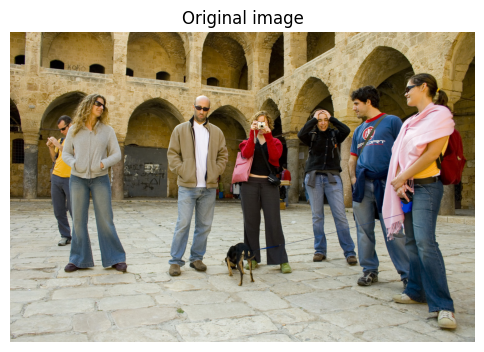

Target Size:   512 x 683 (Reduction: width)
[Pipeline] Classification: 0.07s -> Horizontal
[INFO ] Processed Images Done taking 0.013146638870239258 seconds. Shape:  torch.Size([1, 3, 336, 504])
[INFO ] Model Forward Pass Done. Time: 0.034403324127197266 seconds
[INFO ] Conversion to Prediction Done. Time: 0.00023937225341796875 seconds
[Pipeline] Depth (DA3): 0.05s
[Pipeline] VST saliency: 0.08s
[Pipeline] Energy computation: 0.04s

[Planner] Starting Plan Search...
[Planner] Input Width: 1024, Target Width: 512
[Sim] Starting Seam Simulation. Input Energy Shape: (683, 1024)
[Sim] Simulation done. Projected cost curve min: 56.33, max: 322.37
[Planner] Cumulative Seam Costs calculated. Total removal cost: 118897.40
[Planner] Column Energies calculated. Total Image Energy: 100300.36
[Planner] Checking 60 combinations...
  * New Best: Crop 0, Scale 0.85, Seams 358 (Total: 28318.70)
    Breakdown -> Crop: 0.00, Seam: 26214.92, Scale: 2103.78
  * New Best: Crop 20, Scale 0.85, Seams 324 (T

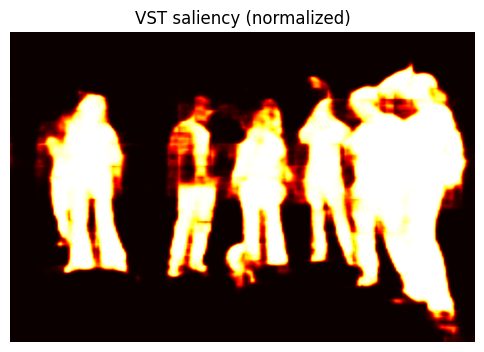

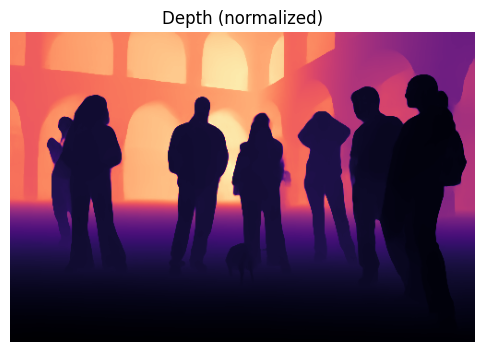

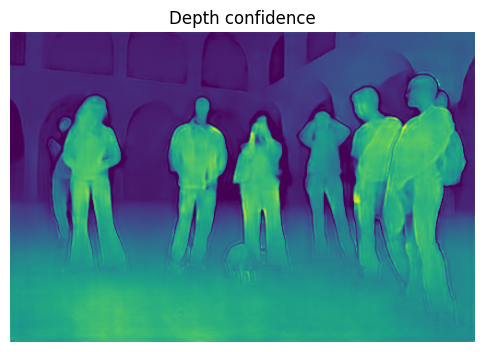

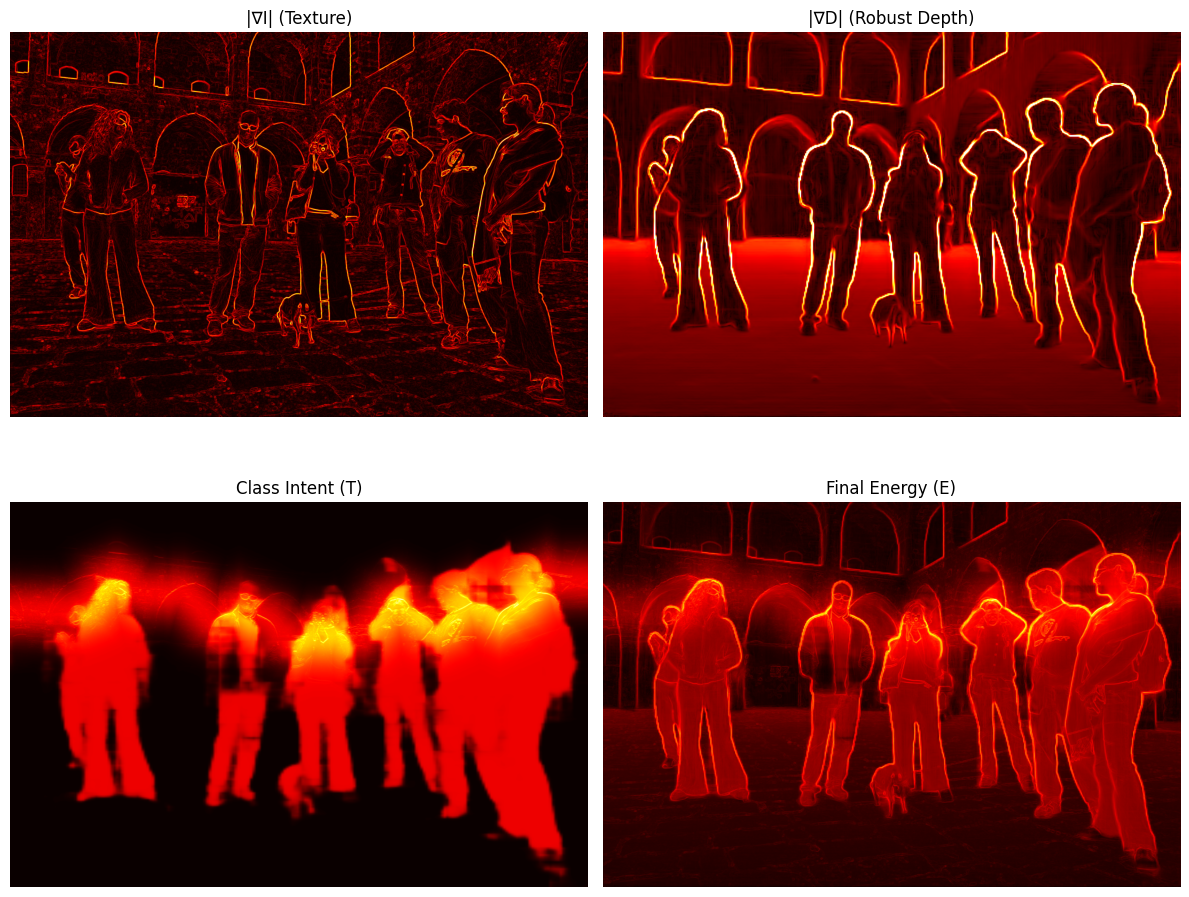

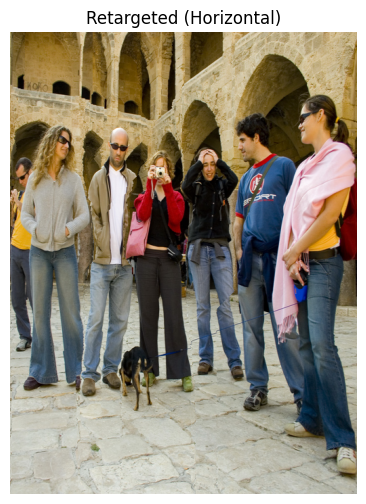


  RETARGETING BREAKDOWN (Horizontal)
Goal: Remove 512 pixels in width.

1. TRASH REMOVAL (Cropping):        80 px
   (Contribution: 15.6%)
2. CONTENT REMOVAL (Seams):        222 px
   (Contribution: 43.4%)
3. GLOBAL SQUEEZE (Planned Scale): 210 px
   (Contribution: 41.0%)
4. SAFETY NET (Rescue Scale):        0 px
   (Contribution: 0.0%)
------------------------------
TOTAL REMOVED: 512 / 512 px

[Info] Scaling was applied in 1 steps.


In [28]:
# %%
# Cell 9: Debug run on a single RetargetMe image with visual outputs AND Statistics

import numpy as np

# 1) Load image
IMG_PATH = "workload_assignments_final/Person_1_Horizon/Horizontal/Umdan.png"  # <- change to any image you like
try:
    rgb = imread(IMG_PATH)
    H, W = rgb.shape[:2]
    print(f"Original Size: {W} x {H}")
    show_image(rgb, "Original image")
except Exception as e:
    print(f"Error loading image: {e}")
    # Fallback to a dummy image if path is wrong, just so code runs
    rgb = np.zeros((100, 100, 3), dtype=np.uint8)
    H, W = 100, 100

# 2) Compute target size (RetargetMe width-only / height-only style)
Wt, Ht = (None, None)
# Assuming these global configs exist from Cell 1, otherwise defaulting
direction = globals().get("RETARGET_DIRECTION", "width")
ratio = globals().get("KEEP_RATIO", 0.5)

if direction == "width":
    Wt = max(1, int(round(W * ratio)))
    Ht = H
else:
    Ht = max(1, int(round(H * ratio)))
    Wt = W
print(f"Target Size:   {Wt} x {Ht} (Reduction: {direction})")

# 3) Run pipeline
# Ensure pipe is initialized (from Cell 8)
if 'pipe' in locals():
    # Force the principled config just in case
    # pipe.cfg.mcfg.penalty = 0.15 # Ensure stiffness is active
    result = pipe.run(rgb, (Wt, Ht))
else:
    print("Pipeline not initialized. Please run Cell 8 first.")
    result = None

if result:
    # 4) Visualize intermediate maps
    dbg = result["energy_dbg"]
    depth = result["depth"]
    conf = result["depth_conf"]
    vst_sal = result["vst_saliency"]

    # a) VST saliency
    if vst_sal is not None:
        show_image(vst_sal, "VST saliency (normalized)", cmap="hot")

    # b) Depth & confidence
    if depth is not None:
        depth_norm = normalize01(depth)
        show_image(depth_norm, "Depth (normalized)", cmap="magma")
    if conf is not None:
        conf_norm = normalize01(conf)
        show_image(conf_norm, "Depth confidence", cmap="viridis")

    # c) Gradient, depth edges, class term, final energy
    # Check if keys exist before plotting to avoid errors
    plots = []
    titles = []
    
    if "G" in dbg: plots.append(dbg["G"]); titles.append("|∇I| (Texture)")
    if "dE" in dbg: plots.append(dbg["dE"]); titles.append("|∇D| (Robust Depth)")
    if "T" in dbg: plots.append(dbg["T"]); titles.append("Class Intent (T)")
    if "E" in dbg: plots.append(dbg["E"]); titles.append("Final Energy (E)")
    # Visualize the smoothed map if you added the blur step
    if "E_smoothed" in dbg: plots.append(dbg["E_smoothed"]); titles.append("Smoothed Energy (for Seams)")
    
    if plots:
        # Dynamic grid layout
        cols = 2
        rows = (len(plots) + 1) // 2
        show_images_grid(
            plots,
            titles=titles,
            cmaps=["hot"] * len(plots),
            cols=cols,
            figsize=(12, 5 * rows),
        )

    # 5) Final retargeted result
    out = result["out"]
    show_image(out, f"Retargeted ({result['pred_class_name']})")

    # --- 6) DETAILED STATISTICS BLOCK (UPDATED FOR PRINCIPLED PIPELINE) ---
    ops_log = result["log"]["ops"]
    
    # A. Calculate Goal
    target_reduction = (W - Wt) if direction == "width" else (H - Ht)
    print("\n" + "="*60)
    print(f"  RETARGETING BREAKDOWN ({result['pred_class_name']})")
    print("="*60)
    print(f"Goal: Remove {target_reduction} pixels in {direction}.\n")

    # B. Parse Logs
    n_seams = ops_log.count("seam")
    
    total_crop_px = 0
    total_rescue_px = 0
    scale_steps = 0
    
    for op in ops_log:
        if op.startswith("crop:"):
            # New format: "crop:10px" (implies 10px from left AND 10px from right)
            try:
                val = int(op.split(":")[1].replace("px", ""))
                total_crop_px += (val * 2) 
            except: pass
        elif op.startswith("rescue_scale:"):
            # Format: "rescue_scale:-50px"
            try:
                val = int(op.split(":")[1].replace("px", ""))
                total_rescue_px += abs(val)
            except: pass
        elif op.startswith("scale:"):
            scale_steps += 1

    # C. Infer Planned Scale
    # Any removal not accounted for by Seams, Crops, or Rescue is "Planned Scaling"
    explained_removal = n_seams + total_crop_px + total_rescue_px
    planned_scale_px = max(0, target_reduction - explained_removal)

    # D. Print Report
    print(f"1. TRASH REMOVAL (Cropping):      {total_crop_px:4d} px")
    print(f"   (Contribution: {total_crop_px / target_reduction * 100:.1f}%)")

    print(f"2. CONTENT REMOVAL (Seams):       {n_seams:4d} px")
    print(f"   (Contribution: {n_seams / target_reduction * 100:.1f}%)")
    
    print(f"3. GLOBAL SQUEEZE (Planned Scale):{planned_scale_px:4d} px")
    print(f"   (Contribution: {planned_scale_px / target_reduction * 100:.1f}%)")
    
    print(f"4. SAFETY NET (Rescue Scale):     {total_rescue_px:4d} px")
    print(f"   (Contribution: {total_rescue_px / target_reduction * 100:.1f}%)")
    
    print("-" * 30)
    print(f"TOTAL REMOVED: {total_crop_px + n_seams + planned_scale_px + total_rescue_px} / {target_reduction} px")
    
    if scale_steps > 0:
        print(f"\n[Info] Scaling was applied in {scale_steps} steps.")
    if total_rescue_px > 0:
        print(f"[Info] RESCUE TRIGGERED! The planner or DDVR saved {total_rescue_px}px of structure.")

In [23]:
# Cell: Hyperparameter sweep (FIXED)

from pathlib import Path
from dataclasses import dataclass, asdict, replace
import json, time, os
import numpy as np

# --- HOT FIX: REDEFINE CONFIG & UPDATE PIPE IN-PLACE ---
# This ensures your existing pipe gets the new 'scaling_bias' field
# without needing to reload the heavy models.

@dataclass
class MultiOpConfig:
    # --- TUNING WEIGHTS ---
    w_cost_crop: float = 0.5
    w_cost_seam: float = 1.0
    w_cost_scale: float = -1.0   # -1.0 triggers Auto-Calibration
    
    # --- NEW BIAS PARAMETER ---
    scaling_bias: float = 0.4
    
    # Constraints
    max_crop_frac: float = 0.1
    min_scale: float = 0.85
    
    # Search resolution
    crop_search_steps: int = 6
    scale_search_steps: int = 10
    crop_px_step: int = 4
    
    # Safety
    ddvr_tau: float = 1.0
    ddvr_max: float = 1.0
    max_seam_frac_after_ops: float = 0.5

# Apply the new config structure to the existing pipeline
if 'pipe' in locals():
    print("Updating pipeline config schema...")
    pipe.cfg.mcfg = MultiOpConfig()
else:
    raise RuntimeError("Please run Cell 8 to initialize 'pipe' first!")

# --------------------------------------------------------------------
# 0) Config: where images live and where to store results
# --------------------------------------------------------------------
images_dir = Path("workload_assignments_final/Person_1_Horizon/Horizontal/")
out_root   = Path("results/hparam_sweep_horizon_v2")
out_root.mkdir(parents=True, exist_ok=True)

# Collect images
exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
image_paths = sorted(p for p in images_dir.rglob("*") if p.suffix.lower() in exts)
print(f"Found {len(image_paths)} images under {images_dir}")

# --------------------------------------------------------------------
# 1) Setup Base Configs
# --------------------------------------------------------------------
pipe.manual_class = 3      
base_ew   = pipe.cfg.ew
base_mcfg = pipe.cfg.mcfg # Now definitely contains scaling_bias
base_HP   = HP_HORIZON

# --------------------------------------------------------------------
# 2) Define Grids
# --------------------------------------------------------------------

energy_grid = [
    dict(name="E_baseline",    w1_grad=0.3, w2_depth=0.7, w3_class=2.0),
    dict(name="E_texture",     w1_grad=0.6, w2_depth=0.4, w3_class=2.0),
    dict(name="E_geometry",    w1_grad=0.1, w2_depth=0.9, w3_class=2.0),
]

horizon_grid = [
    dict(name="H_baseline",    integrity_weight=2.0, sigma_fraction=0.05),
    dict(name="H_strict",      integrity_weight=5.0, sigma_fraction=0.03),
    dict(name="H_loose",       integrity_weight=1.0, sigma_fraction=0.08),
]

# We sweep BIAS now
multi_grid = [
    dict(name="M_Auto_Neutral",  w_cost_scale=-1.0, scaling_bias=1.0),
    dict(name="M_Auto_Cautious", w_cost_scale=-1.0, scaling_bias=0.4),
    dict(name="M_Auto_Paranoid", w_cost_scale=-1.0, scaling_bias=0.1),
    dict(name="M_Trash_Aggressive", w_cost_scale=-1.0, scaling_bias=0.4, w_cost_crop=0.1),
]

# --------------------------------------------------------------------
# 3) Helpers
# --------------------------------------------------------------------
def compute_target_size(rgb):
    H, W = rgb.shape[:2]
    direction = globals().get("RETARGET_DIRECTION", "width")
    ratio     = globals().get("KEEP_RATIO", 0.75)
    if direction == "width":
        target_w = max(1, int(round(W * ratio)))
        target_h = H
    else:
        target_h = max(1, int(round(H * ratio)))
        target_w = W
    return target_w, target_h, direction, ratio

def run_and_save(rgb, target_w, target_h, out_png, meta_path, group, tag):
    t0 = time.time()
    result = pipe.run(rgb, (target_w, target_h))
    elapsed = time.time() - t0

    out = result["out"]
    imwrite(out_png, out)

    # Safely access the config (it definitely exists now)
    bias = getattr(pipe.cfg.mcfg, "scaling_bias", 1.0)
    calib_w = getattr(pipe.cfg.mcfg, "w_cost_scale", -1.0)

    meta = {
        "group": group,
        "tag": tag,
        "input_shape": list(rgb.shape),
        "target_size": [int(out.shape[0]), int(out.shape[1])],
        "elapsed_sec": float(elapsed),
        "ops_log": result["log"]["ops"],
        "scaling_bias": bias,
        "auto_calibrated_weight": calib_w
    }
    with open(meta_path, "w") as f:
        json.dump(meta, f, indent=2)

# --------------------------------------------------------------------
# 4) Main Sweep Loop
# --------------------------------------------------------------------
for img_path in image_paths:
    print("\n" + "=" * 80)
    print(f"Image: {img_path}")

    rgb = imread(img_path)
    target_w, target_h, direction, ratio = compute_target_size(rgb)

    img_root = out_root / img_path.stem
    for d in ["energy", "horizon", "multi"]:
        (img_root / d).mkdir(parents=True, exist_ok=True)

    # 5A) Energy
    HP_HORIZON = base_HP
    pipe.cfg.mcfg = base_mcfg
    for cfg in energy_grid:
        tag = cfg["name"]
        overrides = {k: v for k, v in cfg.items() if k != "name"}
        pipe.cfg.ew = replace(base_ew, **overrides)
        run_and_save(rgb, target_w, target_h, 
                    img_root / "energy" / f"{tag}.png",
                    img_root / "energy" / f"{tag}.json", "energy", tag)

    # 5B) Horizon
    pipe.cfg.ew = base_ew
    pipe.cfg.mcfg = base_mcfg
    for cfg in horizon_grid:
        tag = cfg["name"]
        overrides = {k: v for k, v in cfg.items() if k != "name"}
        HP_HORIZON = replace(base_HP, **overrides)
        run_and_save(rgb, target_w, target_h, 
                    img_root / "horizon" / f"{tag}.png",
                    img_root / "horizon" / f"{tag}.json", "horizon", tag)

    # 5C) MultiOp Bias
    HP_HORIZON = base_HP
    pipe.cfg.ew = base_ew
    for cfg in multi_grid:
        tag = cfg["name"]
        overrides = {k: v for k, v in cfg.items() if k != "name"}
        pipe.cfg.mcfg = replace(base_mcfg, **overrides)
        
        print(f"  [MultiOp] {tag}")
        run_and_save(rgb, target_w, target_h, 
                    img_root / "multi" / f"{tag}.png",
                    img_root / "multi" / f"{tag}.json", "multi", tag)

print("\nSweep complete.")

Updating pipeline config schema...
Found 2 images under workload_assignments_final/Person_1_Horizon/Horizontal

Image: workload_assignments_final/Person_1_Horizon/Horizontal/Umdan.png
[Pipeline] Classification: 0.00s -> Horizontal
[INFO ] Processed Images Done taking 0.007967472076416016 seconds. Shape:  torch.Size([1, 3, 336, 504])
[INFO ] Model Forward Pass Done. Time: 0.036622047424316406 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0005681514739990234 seconds
[Pipeline] Depth (DA3): 0.05s
[Pipeline] VST saliency: 0.08s
[Pipeline] Energy computation: 0.06s
[MultiOp] Plan: Crop 81px | Scale 0.85 | Seams 220
[Pipeline] Retarget (multi-op + seams): 0.56s
[Pipeline] TOTAL TIME: 0.75s
[Pipeline] Classification: 0.00s -> Horizontal
[INFO ] Processed Images Done taking 0.0126495361328125 seconds. Shape:  torch.Size([1, 3, 336, 504])
[INFO ] Model Forward Pass Done. Time: 0.03515291213989258 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0002772808074951172 seconds
[Pipeli